In [84]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Hyperparameter Tuning
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit
from xgboost import XGBRegressor


## Project Modules
import models_utils

In [85]:
## CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [86]:
## HYPERPARAMETER TUNING

def random_search(model, params, X_train, y_train, X_test, y_test):
    tscv = TimeSeriesSplit(n_splits=3)  # Use TimeSeriesSplit for better handling of time-series data
    random = RandomizedSearchCV(model, param_distributions=params, n_iter=200, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
    model_random = random.fit(X_train, y_train)

    print('Best hyperparameters are: '+str(model_random.best_params_))
    print('Best score is: '+str(model_random.best_score_))

    model = model_random.best_estimator_
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print('MSE:', mse)
    print('MAE:', mae)
    return model

In [87]:
## OPEN FILE

lots = pd.read_csv('../clean-files/catalogo_artworks_info.csv', index_col=0)
lots.drop(columns=['Error', '0', '0.1', '0.2', '0.3', '0.4'], inplace=True)

print('Lots count:', lots.shape[0])
print('Lots columns:', lots.columns)

Lots count: 18825
Lots columns: Index(['artist_link', 'Descrição', 'Fonte de Pesquisa', 'Data da Pesquisa',
       'Type', 'Século', 'Artist', 'Título', 'url', 'Década', 'img_url',
       'Medium', 'Height (cm)', 'Width (cm)', 'Area (cm²)', 'Price (BRL)',
       'Price (USD)', 'Price (BRL/cm²)', 'Medium_type', 'Sold',
       'Year of sale'],
      dtype='object')


In [88]:
lots['Medium_type'].value_counts()

Medium_type
pintura       9241
reprodução    4440
desenho       3907
outro         1237
Name: count, dtype: int64

In [89]:
## SELECT ARTISTS

catalogo_artists = [
    'José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti',
    'Candido Portinari (1903-1962)',
    'Di Cavalcanti (1897-1976)',
    'Alberto Guignard - Alberto da Veiga Guignard',
    'Antônio Bandeira (1922-1967)',
    'Ismael Nery',
    'Tarsila do Amaral',
    'Maria Martins',
    'Maria Leontina Franco Da Costa',
    'Djanira da Motta e Silva',
    'Ibere Camargo - Iberê Camargo',
    'Milton Dacosta',
    'Cildo Meireles (1948)',
    'Helio Oiticica - Hélio Oiticica',
    'Annita Catarina Malfatti - Anita Malfatti - Anita Malfati',
]

lots = lots[lots['Artist'].isin(catalogo_artists)]

In [90]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  7347


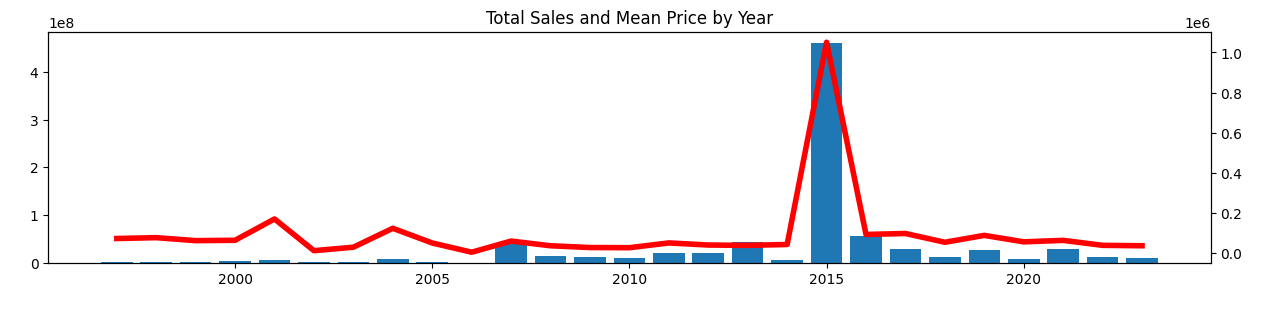

In [91]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
sales = pd.DataFrame(sold_lots.groupby('Year of sale')['Price (BRL)'].sum())
sales['Total Sales'] = sold_lots.groupby('Year of sale')['Price (BRL)'].sum()
sales['Mean Price'] = sold_lots.groupby('Year of sale')['Price (BRL)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [92]:
# TOP ARTISTS BY SALES COUNT

# dataframe with 2 columns: #sales, total sales ($) and mean price ($)
top_artists = pd.DataFrame(sold_lots['Artist'].value_counts())
top_artists['Total Sales'] = sold_lots.groupby('Artist')['Price (BRL)'].sum()
top_artists['Mean Price'] = sold_lots.groupby('Artist')['Price (BRL)'].mean()
# include mean area
top_artists['Mean Area'] = sold_lots.groupby('Artist')['Area (cm²)'].mean()
# mean price per area
top_artists['Mean Price per Area'] = top_artists['Mean Price'] / top_artists['Mean Area']

top_artists = top_artists.sort_values(by='Total Sales', ascending=False)
top_artists.drop('Mean Area', axis=1, inplace=True)
top_artists.head()

,count,Total Sales,Mean Price,Mean Price per Area
Artist,,,,
Alberto Guignard - Alberto da Veiga Guignard,415,507289520.0,1.222384e+06,220.656537
Di Cavalcanti (1897-1976),1015,61140835.0,6.023728e+04,28.740458
Candido Portinari (1903-1962),833,55814932.0,6.700472e+04,55.556588
Antônio Bandeira (1922-1967),704,48389670.0,6.873533e+04,39.381080
José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti,313,45328420.0,1.448192e+05,91.871600


In [93]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (BRL)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 833 lots for Candido Portinari (1903-1962)


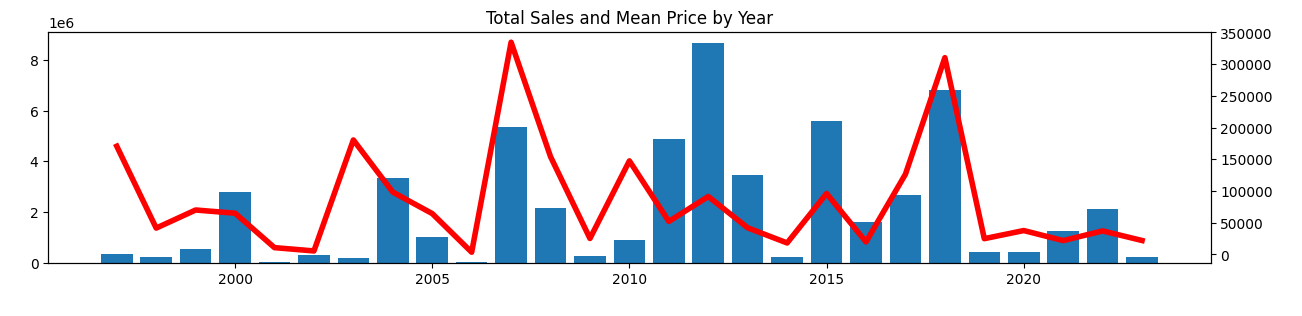

In [94]:
artist_name = 'Candido Portinari (1903-1962)'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (BRL)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (BRL)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (BRL)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [95]:
# lots = lots[lots['Medium_type'] == 'pintura']

In [96]:
## FIT PRICE MODELS

X_train, X_test, y_train, y_test = models_utils.get_df_to_model(lots)
models_df, models = models_utils.fit_models(X_train, y_train, X_test, y_test)

models_df

shape of lots_to_model (before split): (15892, 6)
model features: 20


,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
R2,0.202870,0.934644,0.953356,0.874060
RMSE,531166.847876,152093.232556,128488.592773,211128.942148
MAE,215670.471503,21185.484708,20580.050203,75322.712661


In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve

def perform_search(model, params, X_train, y_train, X_test, y_test, search_type='random'):
    tscv = TimeSeriesSplit(n_splits=3)
    
    if search_type == 'random':
        search = RandomizedSearchCV(model, param_distributions=params, n_iter=200, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
    elif search_type == 'grid':
        search = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
    else:
        raise ValueError("Invalid search_type. Use 'random' or 'grid'.")
    
    model_search = search.fit(X_train, y_train)

    print('Best hyperparameters are: ' + str(model_search.best_params_))
    print('Best score is: ' + str(model_search.best_score_))

    model = model_search.best_estimator_
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print('MSE:', mse)
    print('MAE:', mae)
    
    # train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

    return model#, train_sizes, train_scores, test_scores


def get_model_feature_importances(model, feature_names):
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances_df.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances_df.set_index('feature', inplace=True, drop=True)
    return feature_importances_df


def plot_learning_curve(model, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training examples')
    plt.ylabel(f'Negative {scoring.capitalize()}')  # Adjust the ylabel based on your scoring metric
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()



Best hyperparameters are: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.4}
Best score is: -18222451203.675686
MSE: 13960210639.674782
MAE: 24024.944254047918


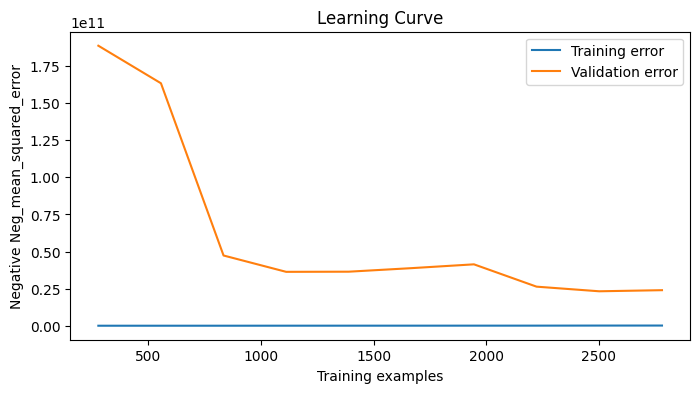

,importance
feature,
Medium_type_pintura,0.303270
Artist_Tarsila do Amaral,0.164203
Height (cm),0.161731
Width (cm),0.134498
Artist_Djanira da Motta e Silva,0.086513
Artist_Maria Leontina Franco Da Costa,0.038929
Year of sale,0.016659
Artist_Candido Portinari (1903-1962),0.014027
Artist_Ismael Nery,0.011965


In [99]:
# XGBoost
xgb = XGBRegressor()
xgb_params = {
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [50, 100, 150, 200],
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_model = perform_search(xgb, xgb_params, X_train, y_train, X_test, y_test)
xgb_feature_importances = get_model_feature_importances(xgb_model, X_train.columns)

plot_learning_curve(xgb_model, X_train, y_train, cv=tscv)
xgb_feature_importances

In [ ]:
## INCLUDE PREDICTED PRICE, ACTUAL PRICE AND ERROR IN TEST SET
model = models['Random Forest']
lots_copy = models_utils.get_predicted_price_and_error(X_test, y_test, model)

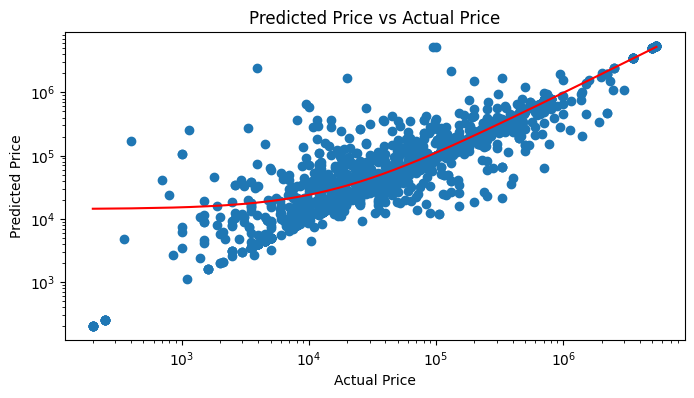

In [ ]:
## COMPARE PREDICTED PRICE VS ACTUAL PRICE
models_utils.plot_predicted_vs_actual_price(lots_copy)

KeyError: 'Medium_type_pintura'

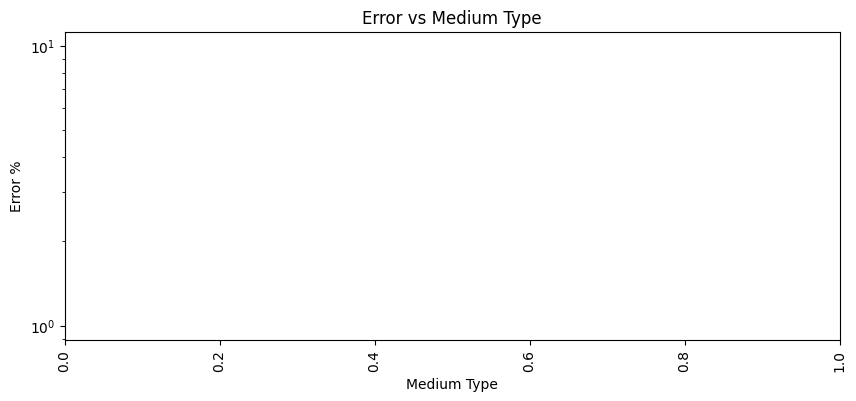

In [ ]:
## COMPARE PCT ERROR ACROSS MEDIUM TYPES

medium_types = ['Medium_type_pintura', 'Medium_type_reprodução'] #, 'desenho']
artists = lots_copy.columns[1:-10]

models_utils.plot_error_by_columns(lots_copy, medium_types, 'Medium Type')
models_utils.plot_error_by_columns(lots_copy, artists, 'Artist')

In [ ]:
# show 10 biggest errors
lots_copy.sort_values('Error %', ascending=False).head(5)

,Artist_Annita Catarina Malfatti - Anita Malfatti - Anita Malfati,Artist_Antônio Bandeira (1922-1967),Artist_Candido Portinari (1903-1962),Artist_Cildo Meireles (1948),Artist_Di Cavalcanti (1897-1976),Artist_Djanira da Motta e Silva,Artist_Helio Oiticica - Hélio Oiticica,Artist_Ibere Camargo - Iberê Camargo,Artist_Ismael Nery,Artist_José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti,...,Height (cm),Medium_type_outro,Medium_type_pintura,Medium_type_reprodução,Width (cm),Year of sale,Predicted Price,Actual Price,Error,Error %
Year,,,,,,,,,,,,,,,,,,,,,
NaN,False,False,False,True,False,False,False,False,False,False,...,14.0,True,False,False,6.5,2023,50511.000000,49.5,50461.500000,1018.424242
1960.0,False,False,False,False,False,False,False,False,False,False,...,44.5,False,False,False,25.0,2007,656395.000000,3000.0,653395.000000,216.798333
1973,False,False,False,False,True,False,False,False,False,False,...,45.0,False,True,False,55.0,2013,99187.250000,500.0,98687.250000,196.374500
NaN,False,False,False,False,False,False,False,False,False,True,...,65.0,True,False,False,46.0,2018,15304.333333,100.0,15204.333333,151.043333
NaN,False,False,False,False,False,False,False,False,False,True,...,65.0,True,False,False,46.0,2018,15304.333333,100.0,15204.333333,151.043333


In [ ]:
## SAVE LOCALLY MODEL AND X_TEST

# # save model to models folder
# model = xgb_model
# with open('./models/catalogo_xgb_model.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # save X_test as csv
# X_test.to_csv('./models/catalogo_X_test.csv', index=False)